# Классификатор для определения наличия диабета у пациентов

**Цель:** Разработать классификатор для определения наличия диабета у пациентов.

**Задачи:**

1. Подготовить данные.
2. Применить методы отбора признаков и интерпретировать результаты с использованием градиентного бустинга и SHAP.
3. Автоматизировать процесс подготовки данных для улучшения качества моделей и упрощения этапов предобработки.

**Структура датасета:**

Датасет состоит из 768 записей и 9 признаков:
1. Pregnancies: Количество беременностей.
2. Glucose: Уровень глюкозы в плазме (за 2 часа теста на толерантность к глюкозе).
3. BloodPressure: Диастолическое артериальное давление (ммрт. ст.).
4. SkinThickness: Толщина кожной складки трицепса (мм).
5. Insulin: Уровень инсулина в сыворотке крови (μU/ml).
6. BMI: Индекс массы тела (вес в кг/(рост в м)^2).
7. DiabetesPedigreeFunction: Функция родства диабета (оценка вероятности диабета на основе наследственности).
8. Age: Возраст (лет).
9. Outcome: Целевая переменная (1 – наличие диабета, 0 – отсутствие диабета).

## 1. Загрузка и исследование данных

In [1]:
!pip install shap

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import pointbiserialr, spearmanr, f, chi2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import f_classif, chi2, RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import shap
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

In [4]:
url='https://drive.google.com/file/d/1Xlh6QSpa_CDE_W4wNmAFPNeIKP0VTN7W/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


явных пропущенных значений нет

In [7]:
# описательная статистика

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


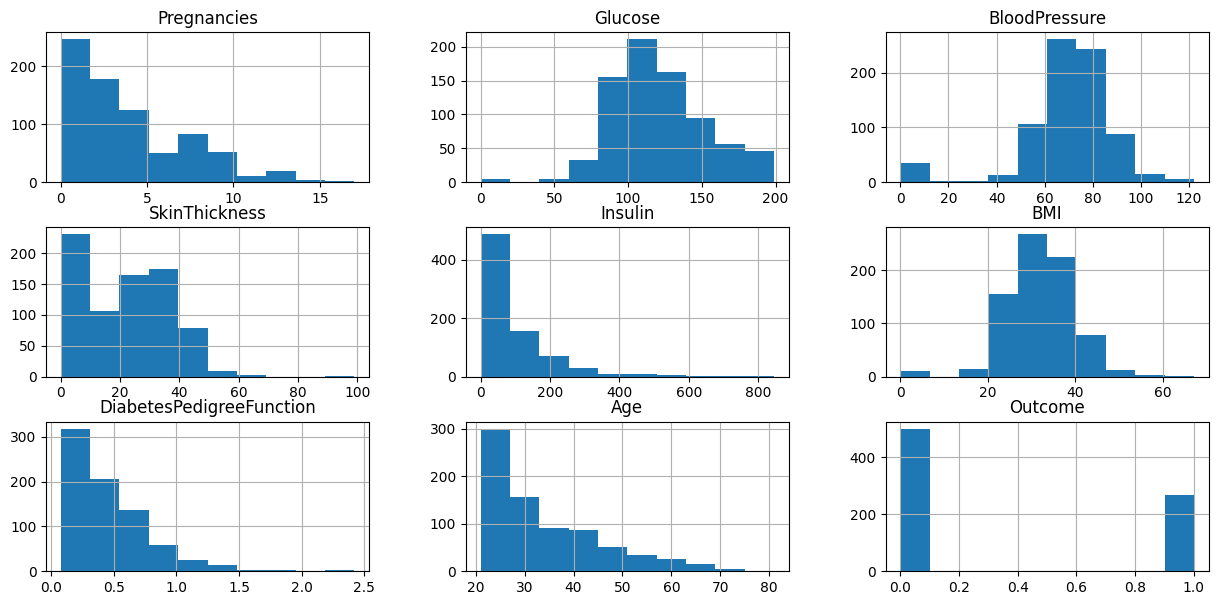

In [8]:
# распределения показателей

df.hist(figsize=(15, 7));

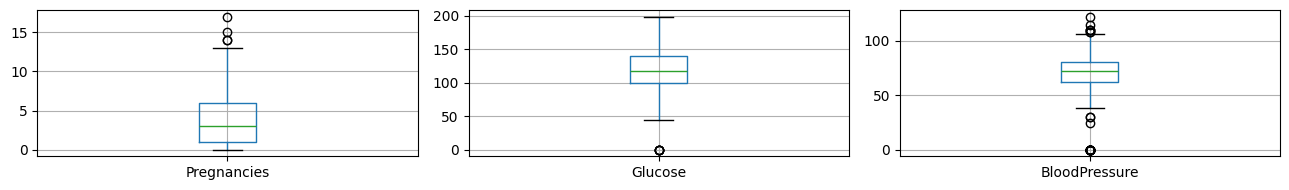

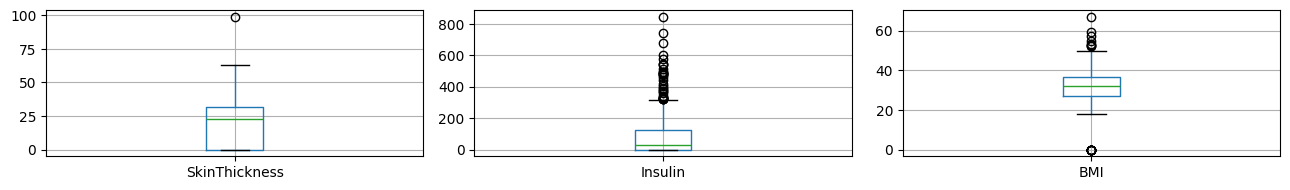

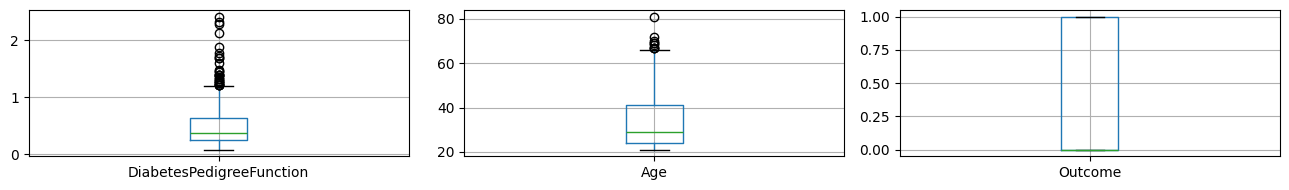

In [9]:
# проверка на выбросы

columns_list = df.columns.tolist()
for j in range(0, 9, 3):
    plt.figure(figsize=(13, 2))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        df.boxplot(columns_list[i+j])
    plt.tight_layout()
    plt.show()

In [10]:
# уровень глюкозы = 0
# df[df['Glucose'] == 0]

# давление = 0
# df[df['BloodPressure'] == 0]

# индекс массы тела = 0
# df[df['BMI'] == 0]

# толщина кожной складки трицепса = 0
# df[df['SkinThickness'] == 0]

# инсулин = 0
# df[df['Insulin'] == 0]

In [11]:
nan_count = df[(df['Glucose'] == 0) |
               (df['BloodPressure'] == 0) |
               (df['BMI'] == 0) |
               (df['SkinThickness'] == 0) |
               (df['Insulin'] == 0)]['BloodPressure'].count()

print(f'Всего нулевых значений: {nan_count} или {nan_count/df.shape[0]:.1%}\n')

print('по глюкозе:', df[df['Glucose'] == 0]['Glucose'].count())
print('по давлению:', df[df['BloodPressure'] == 0]['BloodPressure'].count())
print('по массе тела:', df[df['BMI'] == 0]['BMI'].count())
print('по толщине кожной складки трицепса:', df[df['SkinThickness'] == 0]['BMI'].count())
print('по уровню инсулина:', df[df['Insulin'] == 0]['Insulin'].count())

Всего нулевых значений: 376 или 49.0%

по глюкозе: 5
по давлению: 35
по массе тела: 11
по толщине кожной складки трицепса: 227
по уровню инсулина: 374


По толщине кожной складки трицепса слишком большое количество нулевых значений. Посмотрим, насколько важен этот признак для целевой переменной.

In [12]:
print('Коэффициент линейной корреляции Пирсона:',
       round(df[df['SkinThickness'] != 0][['SkinThickness', 'Outcome']].corr().iloc[1, 0], 3)
)

print('Коэффициент ранговой корреляции Спирмена:',
round(spearmanr(df[df['SkinThickness'] != 0]['SkinThickness'], df[df['SkinThickness'] != 0]['Outcome'])[0], 3),
      'p-value:', round((spearmanr(df[df['SkinThickness'] != 0]['SkinThickness'], df[df['SkinThickness'] != 0]['Outcome'])[1]), 5))

print('Коэффициент точечной бисериальной корреляции:',
      round(pointbiserialr(df[df['SkinThickness'] != 0]['Outcome'], df[df['SkinThickness'] != 0]['SkinThickness'])[0], 3),
      'p-value:', round(pointbiserialr(df[df['SkinThickness'] != 0]['Outcome'], df[df['SkinThickness'] != 0]['SkinThickness'])[0], 5))


Коэффициент линейной корреляции Пирсона: 0.259
Коэффициент ранговой корреляции Спирмена: 0.265 p-value: 0.0
Коэффициент точечной бисериальной корреляции: 0.259 p-value: 0.25949


В целом вклад этого показателя в предсказания будет минимальным. Скорее всего, его можно будет в дальнейшем удалить.

По уровню инсулина в сыворотке крови тоже большое количество нулевых значений, проверим его корреляцию с целевым показателем.

In [13]:
print('Коэффициент линейной корреляции Пирсона:',
       round(df[df['Insulin'] != 0][['Insulin', 'Outcome']].corr().iloc[1, 0], 3)
)

print('Коэффициент ранговой корреляции Спирмена:',
round(spearmanr(df[df['Insulin'] != 0]['Insulin'], df[df['Insulin'] != 0]['Outcome'])[0], 3),
      'p-value:', round((spearmanr(df[df['Insulin'] != 0]['Insulin'], df[df['Insulin'] != 0]['Outcome'])[1]), 5))

print('Коэффициент точечной бисериальной корреляции:',
      round(pointbiserialr(df[df['Insulin'] != 0]['Outcome'], df[df['Insulin'] != 0]['Insulin'])[0], 3),
      'p-value:', round(pointbiserialr(df[df['Insulin'] != 0]['Outcome'], df[df['Insulin'] != 0]['Insulin'])[0], 5))

Коэффициент линейной корреляции Пирсона: 0.303
Коэффициент ранговой корреляции Спирмена: 0.377 p-value: 0.0
Коэффициент точечной бисериальной корреляции: 0.303 p-value: 0.30345


Здесь уже корреляция чуть больше, можно сказать, что она близка к среднему уровню.

*Промежуточный вывод:*

Почти половина наблюдений имеют нулевые значения, причем больше всего таких случаев по переменной SkinThickness и Insulin. Поскольку это медицинская модель, требующая повышенной точности, то я бы просто удалила эти два фактора, чтобы не искажать картину, либо предложила бы провести дополнительное обследование.

По глюкозе, давлению и массе тела я бы удалила единицы наблюдения с нулевыми значениями: их всего около 5%, количество наблюдений не сильно бы изменилось.

Но здесь хотелось бы потренироваться в заполнении пропусков. Поэтому попробуем заполнить пропуски с помощью нескольких моделей.

## 2. Заполнение нулевых значений

Для дальнейшего анализа удалим нулевые значения по глюкозе, давлению и массе тела.

In [14]:
df = df[(df['Glucose'] != 0) & (df['BloodPressure'] != 0) & (df['BMI'] != 0)]

### 2.1. Уровень инсулина в сыворотки крови

In [15]:
# сделаем копию датасета
lr = df.copy()
lr.loc[lr['Insulin'] == 0, 'Insulin'] = np.NaN

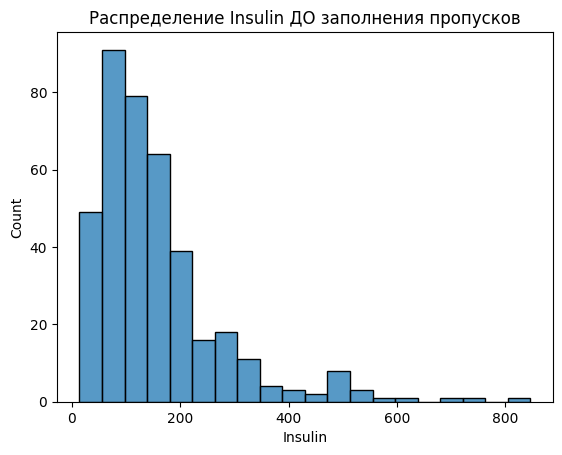

In [16]:
# посмотрим на распределение Insulin до заполнения пропусков
sns.histplot(lr[lr['Insulin'].isnull()==False]['Insulin'], bins = 20)
plt.title('Распределение Insulin ДО заполнения пропусков');

In [17]:
# среднее и медина Insulin до заполнения пропусков
print('Среднее по столбцу Insulin до заполнения пропусков:',
      round(lr[lr['Insulin'].isnull()==False]['Insulin'].mean(), 3))
print('Медиана по столбцу Insulin до заполнения пропусков:',
      round(lr[lr['Insulin'].isnull()==False]['Insulin'].median(), 3))

Среднее по столбцу Insulin до заполнения пропусков: 156.056
Медиана по столбцу Insulin до заполнения пропусков: 125.5


In [18]:
# стандартизация
scaler = StandardScaler()
lr = pd.DataFrame(scaler.fit_transform(lr), columns = lr.columns)

In [19]:
# получение train-, test-выборок
test = lr[lr['Insulin'].isnull()].copy()
train = lr.dropna().copy()
# разбиение на x и y
y_train = train['Insulin']
X_train = train.drop(['Insulin', 'Outcome', 'SkinThickness'], axis=1)
X_test = test.drop(['Insulin', 'Outcome', 'SkinThickness'], axis=1)

Здесь нужно было выбрать подходящую модель, я остановила свой выбор на XGBRegressor. Сейчас покажу почему.

In [20]:
def get_metrics(model):
  m = model
  m.fit(X_train, y_train)
  y_pred_train = m.predict(X_train)
  mse = mean_squared_error(y_train, y_pred_train)
  r2 = r2_score(y_train, y_pred_train)
  print("R2:", round(r2, 3))
  print("RMSE:", (round(np.sqrt(mse), 3)))
  print("MSE:", round(mse, 3))

In [21]:
print('Линейная регрессия')
get_metrics(LinearRegression())

Линейная регрессия
R2: 0.357
RMSE: 0.802
MSE: 0.643


In [22]:
print('Дерево решений')
get_metrics(DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, random_state=42))

Дерево решений
R2: 0.583
RMSE: 0.646
MSE: 0.417


In [23]:
print('Случайный лес')
get_metrics(RandomForestRegressor(max_depth=5, min_samples_leaf=2, random_state=42, n_estimators=100))

Случайный лес
R2: 0.64
RMSE: 0.6
MSE: 0.36


In [24]:
print('Градиентный бустинг')
get_metrics(xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.2))

Градиентный бустинг
R2: 0.982
RMSE: 0.135
MSE: 0.018


Теперь на основе градиентного бустинга получим значения уровня инсулина для тех наблюдений, по которым стоят нули.

In [25]:
lr_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.2)
lr_model.fit(X_train, y_train)
# получение предсказанных значений
y_pred = lr_model.predict(X_test)
test['Insulin'] = y_pred

In [26]:
# объединение выборок
lr = pd.concat([train, test])

In [27]:
# восстановление значений
lr.sort_index(inplace = True)
lr = pd.DataFrame(scaler.inverse_transform(lr), columns = lr.columns)

In [28]:
# установим минимальное значение на уровне 0,5
lr.Insulin.clip(lower = 0.5, inplace = True)

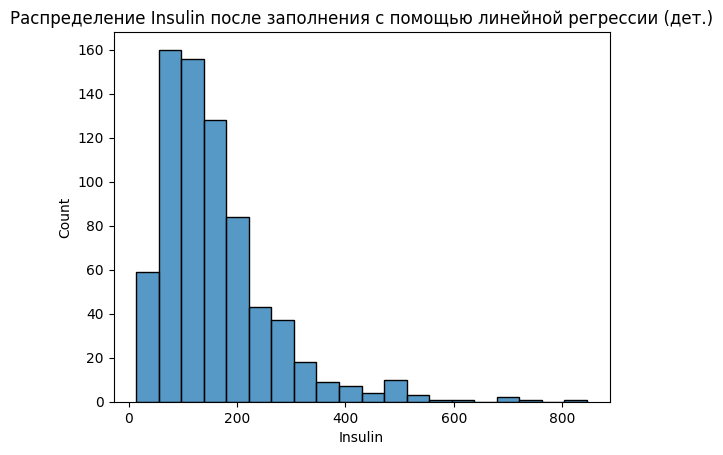

In [29]:
# посмотрим на распределение Insulin
sns.histplot(lr['Insulin'], bins = 20)
plt.title('Распределение Insulin после заполнения с помощью линейной регрессии (дет.)');

In [30]:
# среднее и медина Insulin после заполнения пропусков
print('Среднее по столбцу Insulin после заполнения пропусков:',
      round(lr[lr['Insulin'].isnull()==False]['Insulin'].mean(), 3))
print('Медиана по столбцу Insulin после заполнения пропусков:',
      round(lr[lr['Insulin'].isnull()==False]['Insulin'].median(), 3))

Среднее по столбцу Insulin после заполнения пропусков: 159.113
Медиана по столбцу Insulin после заполнения пропусков: 133.903


Распределение почти не изменилось, но изменились медиана и среднее значение.

### 2.2. Толщина кожной складки трицепса

Здесь мы видели выбросы справа, посмотрим внимательнее на них.

In [31]:
df[df['SkinThickness'] > 60]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
445,0,180,78,63,14,59.4,2.420,25,1
579,2,197,70,99,0,34.7,0.575,62,1


Поскольку итог в обоих случаях 1, то можно заменить значение 99 на 70, чтобы сильно не искажать линейную модель, которая чувствительно к выбросам.

In [32]:
# сделаем копию датасета
lr = df.copy()
lr.loc[lr['SkinThickness'] > 70, 'SkinThickness'] = 70
lr.loc[lr['SkinThickness'] == 0, 'SkinThickness'] = np.NaN

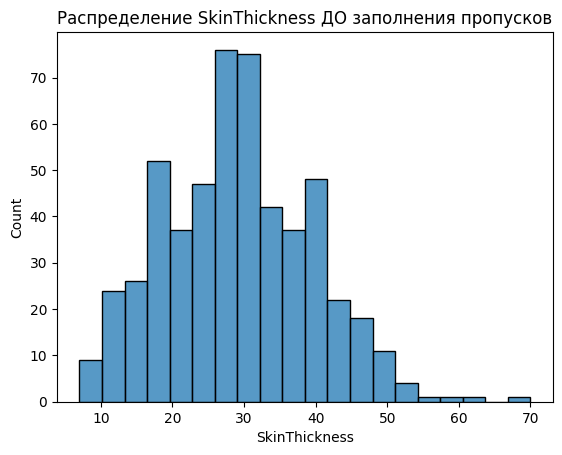

In [33]:
# посмотрим на распределение SkinThickness до заполнения пропусков
sns.histplot(lr[lr['SkinThickness'].isnull()==False]['SkinThickness'], bins = 20)
plt.title('Распределение SkinThickness ДО заполнения пропусков');

In [34]:
# среднее и медина SkinThickness до заполнения пропусков
print('Среднее по столбцу SkinThickness до заполнения пропусков:',
      round(lr[lr['SkinThickness'].isnull()==False]['SkinThickness'].mean(), 3))
print('Медиана по столбцу Insulin до заполнения пропусков:',
      round(lr[lr['SkinThickness'].isnull()==False]['SkinThickness'].median(), 3))

Среднее по столбцу SkinThickness до заполнения пропусков: 29.128
Медиана по столбцу Insulin до заполнения пропусков: 29.0


In [35]:
# стандартизация
scaler = StandardScaler()
lr = pd.DataFrame(scaler.fit_transform(lr), columns = lr.columns)

# получение train-, test-выборок
test = lr[lr['SkinThickness'].isnull()].copy()
train = lr.dropna().copy()
# разбиение на x и y
y_train = train['SkinThickness']
X_train = train.drop(['SkinThickness', 'Outcome'], axis=1)
X_test = test.drop(['SkinThickness', 'Outcome'], axis=1)

In [36]:
get_metrics(xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.2))

R2: 0.968
RMSE: 0.179
MSE: 0.032


In [37]:
# модель
lr_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.2)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
test['SkinThickness'] = y_pred
# объединение выборок
lr = pd.concat([train, test])

# восстановление значений
lr.sort_index(inplace = True)
lr = pd.DataFrame(scaler.inverse_transform(lr), columns = lr.columns)

# установим минимальное значение на уровне 5
lr.SkinThickness.clip(lower = 5, inplace = True)

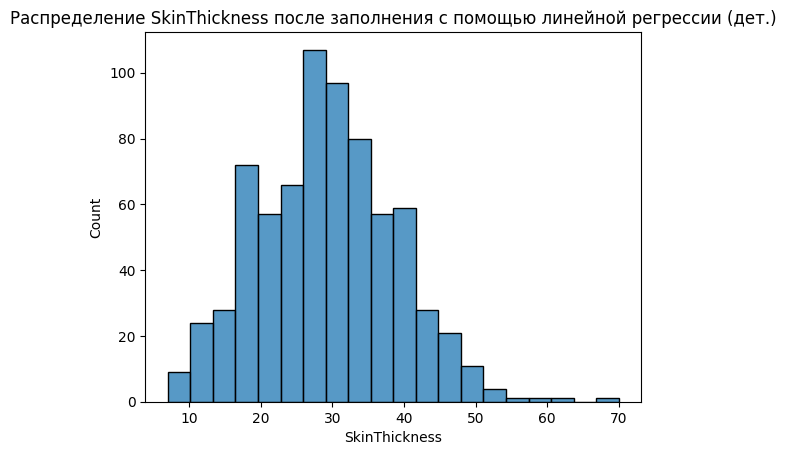

In [38]:
# посмотрим на распределение SkinThickness
sns.histplot(lr['SkinThickness'], bins = 20)
plt.title('Распределение SkinThickness после заполнения с помощью линейной регрессии (дет.)');

In [39]:
# среднее и медина SkinThickness после заполнения пропусков
print('Среднее по столбцу SkinThickness после заполнения пропусков:',
      round(lr[lr['SkinThickness'].isnull()==False]['SkinThickness'].mean(), 3))
print('Медиана по столбцу SkinThickness после заполнения пропусков:',
      round(lr[lr['SkinThickness'].isnull()==False]['SkinThickness'].median(), 3))

Среднее по столбцу SkinThickness после заполнения пропусков: 29.213
Медиана по столбцу SkinThickness после заполнения пропусков: 29.0


Здесь почти не изменились распределение и стат. оценки. Значит, более надежно заполнились нулевые значения.

## 3. Отбор признаков

### 3.1. Фильтрационные методы (корр. анализ)

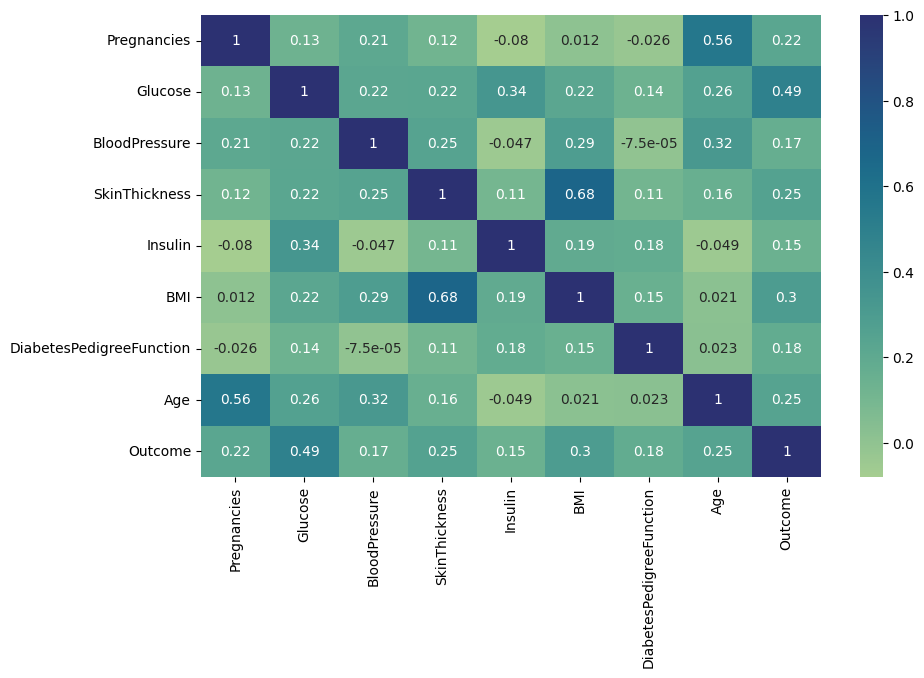

In [40]:
correlation_matrix = lr.corr()

# корреляционная матрица
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="crest")
plt.show()

In [41]:
target_correlation = correlation_matrix['Outcome'].abs().sort_values(ascending=False)
print('Количество фичей с границей в 0,1:',
      len(target_correlation[target_correlation > 0.1].index)-1,
      '\nИх список:\n',
      '\n '.join(target_correlation[target_correlation > 0.1].index[1:])
      )

Количество фичей с границей в 0,1: 8 
Их список:
 Glucose
 BMI
 SkinThickness
 Age
 Pregnancies
 DiabetesPedigreeFunction
 BloodPressure
 Insulin


In [42]:
print('Количество фичей с границей в 0,2:',
      len(target_correlation[target_correlation > 0.2].index)-1,
      '\nИх список:\n',
      '\n '.join(target_correlation[target_correlation > 0.2].index[1:])
      )

Количество фичей с границей в 0,2: 5 
Их список:
 Glucose
 BMI
 SkinThickness
 Age
 Pregnancies


Здесь наиболее значимыми признаками для построения модели оказались: Уровень глюкозы, Индекс массы тела, Толщина кожной складки трицепса, Возраст, Количество беременностей.

Также здесь мы можем видеть наличие мультиколлениарности между признаками Толщина кожной складки трицепса и Индекс массы тела, что вполне логично. В дальнейшем один из показателей нужно будет исключить из модели.

### 3.2. Фильтрационные методы (ANOVA)

In [43]:
X = lr.drop('Outcome', axis=1)
y = lr['Outcome']

# Применение метода ANOVA (f_classif)
F, p_values = f_classif(X, y)

# Выбор значимых признаков (например, с p-value < 0.05)
anova_results = pd.DataFrame({'Feature': X.columns, 'F-Statistic': F, 'p-value': p_values})
anova_results[anova_results['p-value'] < 0.05].sort_values(by='F-Statistic', ascending=False)

,Feature,F-Statistic,p-value
1,Glucose,226.152520,1.150170e-44
5,BMI,71.080260,1.857173e-16
3,SkinThickness,49.499635,4.616057e-12
7,Age,46.402860,2.029892e-11
0,Pregnancies,38.290564,1.021177e-09
6,DiabetesPedigreeFunction,25.571087,5.411395e-07
2,BloodPressure,20.637931,6.502038e-06
4,Insulin,15.612888,8.535596e-05


In [44]:
# посмотрим на границу f-статистики
f.ppf(1-0.05, dfn=(X.shape[0]-1), dfd=1)

254.13793948140946

Здесь также Уровень инсулина в сыворотке крови, Артериальное давление и  Функция родства диабета оказывают самое слабое влияние на целевую переменную. Близкой к сильной связью обладает только переменная по уровню глюкозы.

### 3.3. Фильтрационные методы (хи-квадрат)

In [45]:
# Применение теста χ²
chi2_stat, p_val = chi2(X, y)

chi2_results = pd.DataFrame({'Feature': X.columns, 'Хи-квадрат': chi2_stat, 'p-value': p_val})
chi2_results[chi2_results['p-value'] < 0.05].sort_values(by='Хи-квадрат', ascending=False)

,Feature,Хи-квадрат,p-value
4,Insulin,2480.042019,0.000000e+00
1,Glucose,1337.860753,6.693284e-293
7,Age,181.217569,2.627729e-41
3,SkinThickness,143.741242,4.047294e-33
0,Pregnancies,106.509645,5.701434e-25
5,BMI,94.717718,2.195651e-22
2,BloodPressure,42.532180,6.952885e-11
6,DiabetesPedigreeFunction,5.752492,1.646529e-02


In [46]:
# критический уровень хи-квадрат
scipy.stats.chi2.ppf(1-0.05, df=767)

832.5396834073772

Здесь тоже похожая ситуация: у показателей Функция родства диабета и Артериальное давление слабое влияние на целевую переменную и низкая статистическая значимость. Сильная связь по показателю уровня глюкозы. Здесь впервые тест показал наличие сильной связи у показателя по инсулину. Проверим, не повлияло ли заполнение пропусков на эту связь.

In [47]:
# Применение теста χ² для данных до заполнения пропусков
X_before = df[(df['Insulin'] != 0) &
              (df['SkinThickness'] != 0)].drop('Outcome', axis=1)
y_before = df[(df['Insulin'] != 0) &
              (df['SkinThickness'] != 0)]['Outcome']

chi2_stat_2, p_val_2 = chi2(X_before, y_before)

chi2_results_2 = pd.DataFrame({'Feature': X_before.columns, 'Хи-квадрат': chi2_stat_2, 'p-value': p_val_2})
chi2_results_2[chi2_results_2['p-value'] < 0.05].sort_values(by='Хи-квадрат', ascending=False)

,Feature,Хи-квадрат,p-value
4,Insulin,3215.172502,0.000000e+00
1,Glucose,807.609432,1.195758e-177
7,Age,162.221496,3.700825e-37
3,SkinThickness,97.186150,6.310655e-23
0,Pregnancies,80.412215,3.039107e-19
5,BMI,42.585260,6.766741e-11
2,BloodPressure,32.075570,1.482904e-08
6,DiabetesPedigreeFunction,3.909884,4.800290e-02


In [48]:
# критический уровень хи-квадрат по ненулевой половине данных
degree = df[(df['Insulin'] != 0) &
              (df['SkinThickness'] != 0)]['Outcome'].count() - 1
scipy.stats.chi2.ppf(1-.05, df=degree)

438.1057766434272

Влияние показателя Insulin на целевую переменную было изначально тоже велико. Видимо, здесь связь более сложная, нелинейная и немонотонная, поскольку другие тесты не показали ее наличие.

### 3.4. Оберточные методы (RFE)

Index(['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')
Accuracy: 0.7706422018348624


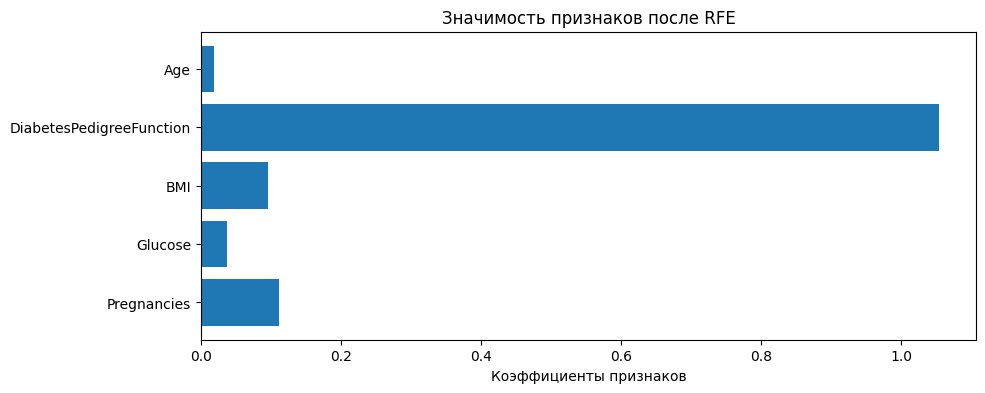

In [49]:
# разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# модель для RFE
model = LogisticRegression(max_iter=10000)
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(X_train, y_train)

# отбор признаков
selected_features = X.columns[rfe.support_]
print(selected_features)

# обучение модели на выбранных признаках
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)

# оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# визуализация значимости признаков
plt.figure(figsize=(10, 4))
plt.barh(selected_features, model.coef_[0])
plt.xlabel('Коэффициенты признаков')
plt.title('Значимость признаков после RFE')
plt.show()

Отобралось 5 признаков, но их влияние отличется от фильтрационных методов. Теперь самым значимым фактором оказалась наследственность.

### 3.5. Оберточные методы (SFS)

Selected features: ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction']
Mean Squared Error: 0.16328951230549682


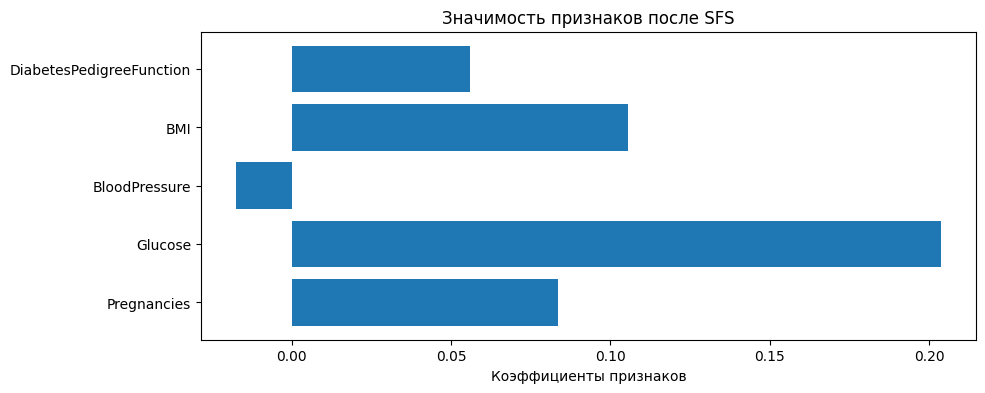

In [50]:
# стандартизация
scaler = StandardScaler()
X_st = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

# разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_st, y, test_size=0.3, random_state=42)

# модель для SFS
model = LinearRegression()
sfs = SFS(model,
          k_features=5,
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',
          cv=5)

sfs = sfs.fit(X_train, y_train)

# отбор признаков
selected_features = list(sfs.k_feature_names_)
print('Selected features:', selected_features)

# обучение модели на выбранных признаках
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)
model.fit(X_train_sfs, y_train)
y_pred = model.predict(X_test_sfs)

# оценка качества модели
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# визуализация значимости признаков
plt.figure(figsize=(10, 4))
plt.barh(selected_features, model.coef_)
plt.xlabel('Коэффициенты признаков')
plt.title('Значимость признаков после SFS')
plt.show()


Самым сильным влиянием обладает уровень глюкозы, что согласуется с фильтрационными методами. Правда, MSE великовата, поэтому результат не имеет необходимой статистической значимости.

### 3.6. Встроенные методы (случайный лес)

#### 3.6.1. По датасету с заполненными нулевыми значениями

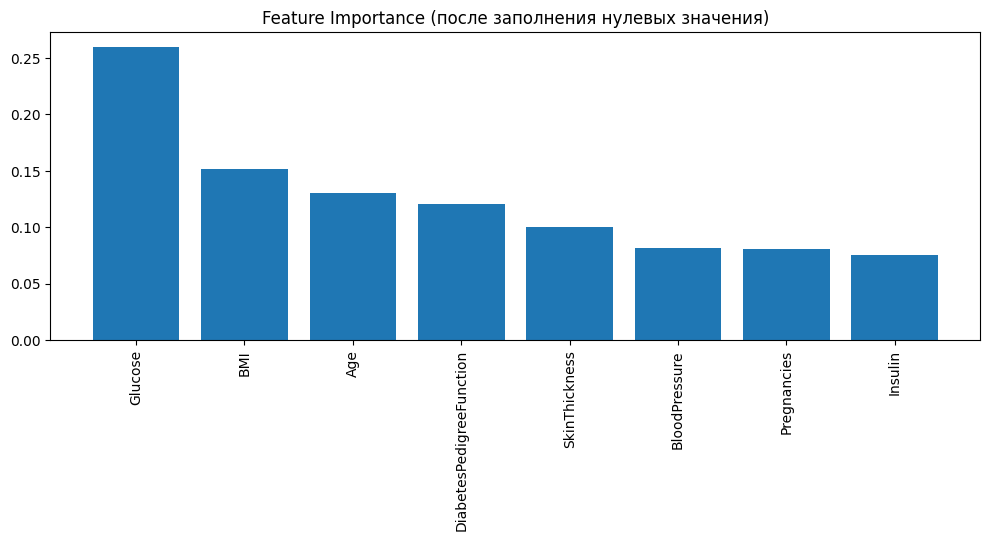

In [51]:
feature_names = X.columns.values.tolist()

# модель Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# оценка значимости признаков
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# визуализация значимости признаков
plt.figure(figsize=(12, 4))
plt.title("Feature Importance (после заполнения нулевых значения)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.show()

#### 3.6.2. По датасету с изначально ненулевыми значениями

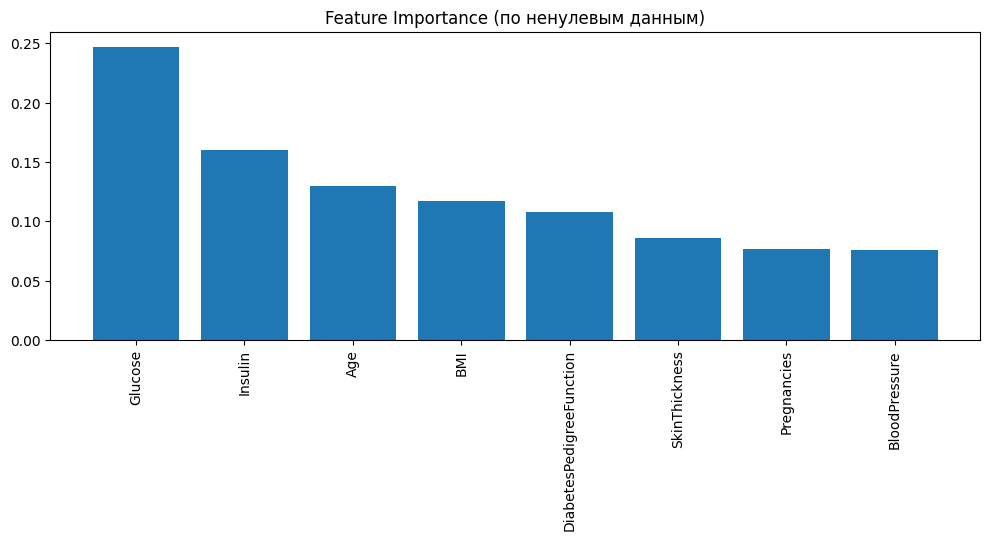

In [52]:
# модель Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_before, y_before)

# оценка значимости признаков
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# визуализация значимости признаков
plt.figure(figsize=(12, 4))
plt.title("Feature Importance (по ненулевым данным)")
plt.bar(range(X_before.shape[1]), importances[indices], align="center")
plt.xticks(range(X_before.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.show()

Здесь мы видим, как сильно мы изменили показатель Insulin и его влияние на целевую переменную, когда заполняли нулевые значения. Поэтому лучше не использовать этот показатель в дальнейшем.

### 3.7. Градиентный бустинг (LightGBM)

#### 3.7.1. Отбор фич

In [53]:
# модель LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# оценка значимости признаков
importances = lgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

[LightGBM] [Info] Number of positive: 180, number of negative: 326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 506, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.355731 -> initscore=-0.593941
[LightGBM] [Info] Start training from score -0.593941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [54]:
# оценка качества модели
y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7431192660550459


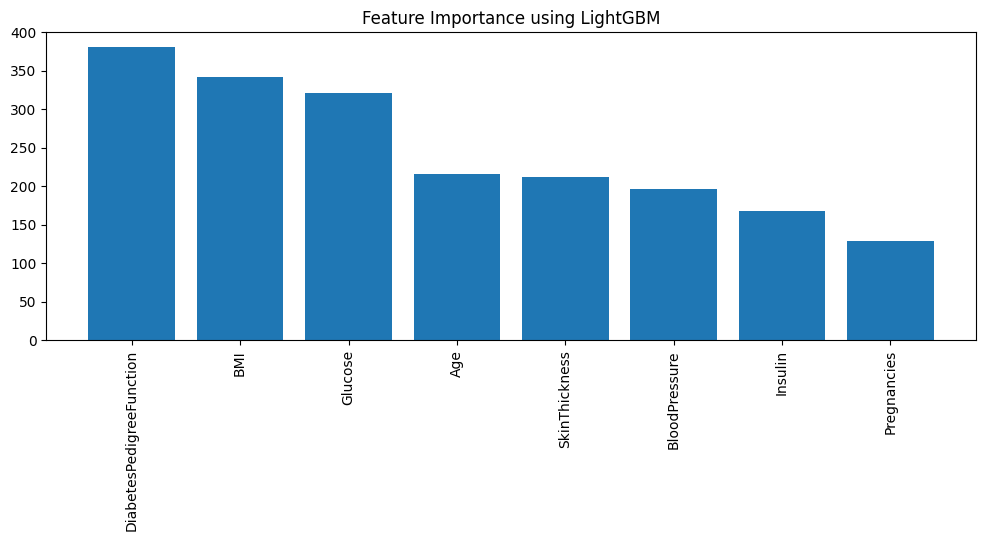

In [55]:
# визуализация значимости признаков
plt.figure(figsize=(12, 4))
plt.title("Feature Importance using LightGBM")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.show()

Здесь результаты отличаются от тех, что мы получали ранее. Но в целом, если нужно сделать отбор фич, то исключить стоит только показать по уровню инсулина, поскольку именно он вызывает больше всего противоречий.

#### 3.7.2. Финальное обучение модели

In [56]:
X = lr.drop(['Insulin', 'Outcome'], axis=1)
y = lr['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# модель LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# оценка значимости признаков
importances = lgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

[LightGBM] [Info] Number of positive: 180, number of negative: 326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 506, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.355731 -> initscore=-0.593941
[LightGBM] [Info] Start training from score -0.593941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [57]:
# оценка качества модели
y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy на тестовой выборке: {accuracy}")

Accuracy на тестовой выборке: 0.7431192660550459


К сожалению, качество модели недостаточно высокое.

## 4. Интерпретация результатов

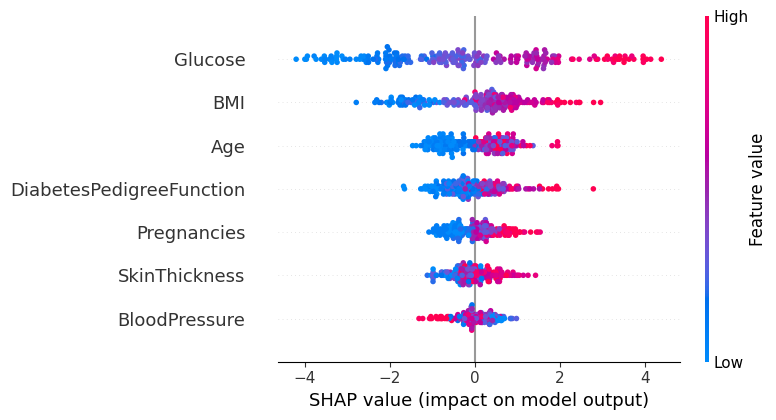

In [58]:
# Инициализация Explainer
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_test)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X_test)

Здесь мы видим, что наибольшее влияние на диагноз оказал уровень глюкозы в крови, что согласуется с общей медицинской практикой. Также судя по распределению здесь прямая зависимость.
Кроме того, на факт наличия диабета оказали влияние возраст, индекс массы тела и функция родства. Остальные 3 фактора не столь сильно и очевидно влияют на диагноз.

**Вывод:**

По итогам анализа мы получили не очень сильную модель, подтвердили сильное влияние на диагноз уровня глюкозы в крови, возраста и индекса массы тела. Чтобы модель была более качественной необходимо получить больше единиц наблюдения и повысить точность данных.

## Дополнительный раздел: автоматизация процесса подготовки данных для RandomForest и LightGBM.

Прежде чем включать в пайплайн ту или иную стратегию, я попробовала 2 алгоритма заполнения пропусков: IterativeImputer и KNNImputer. Далее выбрала одну стратегию исходя из того, какая из них меньше всего отвела медианное значение от реального распределения.

In [59]:
# разделение данных на признаки и целевую переменную
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# список фичей
features_list = X[['Glucose', 'BloodPressure', 'BMI',
                   'SkinThickness', 'Insulin']].columns.tolist()

# запоним средние и медианные значения до начала заполнения пропусков
mean_before = df[(df['Glucose'] != 0) &
                 (df['BloodPressure'] != 0) &
                 (df['BMI'] != 0) &
                 (df['SkinThickness'] != 0) &
                 (df['Insulin'] != 0)][features_list].mean()

median_before = df[(df['Glucose'] != 0) &
                 (df['BloodPressure'] != 0) &
                 (df['BMI'] != 0) &
                 (df['SkinThickness'] != 0) &
                 (df['Insulin'] != 0)][features_list].median()

std_before = df[(df['Glucose'] != 0) &
                 (df['BloodPressure'] != 0) &
                 (df['BMI'] != 0) &
                 (df['SkinThickness'] != 0) &
                 (df['Insulin'] != 0)][features_list].std()

dis_before = pd.DataFrame({'Среднее': round(mean_before, 1), 'Медиана': round(median_before, 1), 'Ср.кв.откл.': round(std_before, 1)})
dis_before

,Среднее,Медиана,Ср.кв.откл.
Glucose,122.6,119.0,30.9
BloodPressure,70.7,70.0,12.5
BMI,33.1,33.2,7.0
SkinThickness,29.1,29.0,10.5
Insulin,156.1,125.5,118.8


In [63]:
# Использование IterativeImputer

features_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(missing_values=0, initial_strategy='median'))
])
features_transformer.fit(X)
X_iterative=features_transformer.transform(X)
X_iterative = pd.DataFrame(X_iterative, columns=X.columns)
print('Количество нулевых значений:', X_iterative[(X_iterative['Glucose'] == 0) |
                                                  (X_iterative['BloodPressure'] == 0) |
                                                  (X_iterative['BMI'] == 0) |
                                                  (X_iterative['SkinThickness'] == 0) |
                                                  (X_iterative['Insulin'] == 0)]['BloodPressure'].count()
)

Количество нулевых значений: 0


In [64]:
# запомним медиану и среднее
mean_iterative = X_iterative[features_list].mean()

median_iterative = X_iterative[features_list].median()

std_iterative = X_iterative[features_list].std()

dis_before['Среднее II'] = pd.DataFrame(mean_iterative).round(1)
dis_before['Медиана II'] = pd.DataFrame(median_iterative).round(1)
dis_before['Ср.кв.откл. II'] = pd.DataFrame(std_iterative).round(1)
dis_before

,Среднее,Медиана,Ср.кв.откл.,Среднее II,Медиана II,Ср.кв.откл. II
Glucose,122.6,119.0,30.9,121.9,117.0,30.8
BloodPressure,70.7,70.0,12.5,72.4,72.0,12.4
BMI,33.1,33.2,7.0,32.5,32.4,6.9
SkinThickness,29.1,29.0,10.5,29.0,28.8,9.7
Insulin,156.1,125.5,118.8,153.2,130.0,99.2


In [65]:
# использование KNNImputer
features_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(missing_values=0, n_neighbors=5))
])
features_transformer.fit(X)
X_KNN = features_transformer.transform(X)
X_KNN = pd.DataFrame(X_KNN, columns=X.columns)
print('Количество нулевых значений:', X_KNN[(X_KNN['Glucose'] == 0) |
                                            (X_KNN['BloodPressure'] == 0) |
                                            (X_KNN['BMI'] == 0) |
                                            (X_KNN['SkinThickness'] == 0) |
                                            (X_KNN['Insulin'] == 0)]['BloodPressure'].count()
)

Количество нулевых значений: 0


In [66]:
# запомним медиану и среднее
mean_KNN = X_KNN[features_list].mean()

median_KNN = X_KNN[features_list].median()

std_KNN = X_KNN[features_list].std()

dis_before['Среднее KNN'] = pd.DataFrame(mean_KNN).round(1)
dis_before['Медиана KNN'] = pd.DataFrame(median_KNN).round(1)
dis_before['Ср.кв.откл. KNN'] = pd.DataFrame(median_KNN).round(1)

# посмотрим, что ближе к изначальному распределению
dis_before['II Δ ср'] = dis_before['Среднее II'] - dis_before['Среднее']
dis_before['KNN Δ ср'] = dis_before['Среднее KNN'] - dis_before['Среднее']

dis_before['II Δ мед'] = dis_before['Медиана II'] - dis_before['Медиана']
dis_before['KNN Δ мед'] = dis_before['Медиана KNN'] - dis_before['Медиана']

dis_before['II Δ std'] = dis_before['Ср.кв.откл. II'] - dis_before['Ср.кв.откл.']
dis_before['KNN Δ std'] = dis_before['Ср.кв.откл. KNN'] - dis_before['Ср.кв.откл.']

dis_before

,Среднее,Медиана,Ср.кв.откл.,Среднее II,Медиана II,Ср.кв.откл. II,Среднее KNN,Медиана KNN,Ср.кв.откл. KNN,II Δ ср,KNN Δ ср,II Δ мед,KNN Δ мед,II Δ std,KNN Δ std
Glucose,122.6,119.0,30.9,121.9,117.0,30.8,121.9,117.0,117.0,-0.7,-0.7,-2.0,-2.0,-0.1,86.1
BloodPressure,70.7,70.0,12.5,72.4,72.0,12.4,72.4,72.0,72.0,1.7,1.7,2.0,2.0,-0.1,59.5
BMI,33.1,33.2,7.0,32.5,32.4,6.9,32.5,32.4,32.4,-0.6,-0.6,-0.8,-0.8,-0.1,25.4
SkinThickness,29.1,29.0,10.5,29.0,28.8,9.7,29.1,29.0,29.0,-0.1,0.0,-0.2,0.0,-0.8,18.5
Insulin,156.1,125.5,118.8,153.2,130.0,99.2,154.7,135.0,135.0,-2.9,-1.4,4.5,9.5,-19.6,16.2


Здесь мы видим, что всех, кроме Insulin лучше всего заполнены пропуски с помощью IterativeImputer. Для Insulin результаты получились в обоих случаях сильно отклоненные. В домашнем задании я уже отмечала, что это достаточно противоречивый показатель, от которого стоит отказаться. Здесь это еще раз подтвердилось.

Для построения пайплайна выберем IterativeImputer.

In [67]:
# создание пайплайна с двумя шагами: заполнение пропусков и стандартизация
features_list = X.columns.tolist()
features_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(missing_values=0, initial_strategy='median')),
    ('scaler', StandardScaler())
])
features_transformer.fit(X)
X_filled=features_transformer.transform(X)

In [68]:
# построение модели
# сплит выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# определение моделей
models = {
    'RandomForest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier()
}

# определение гиперпараметров для поиска
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [10, 20]
    },
    'LightGBM': {
        'classifier__n_estimators': [50, 100]
    }
}

# обучение моделей

results = {}

for model_name in models:
    pipeline = Pipeline([('classifier', models[model_name])])

    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)

    results[model_name] = {
        'Best Model': best_model,
        'Best Score (CV)': best_score,
        'Best Params': best_params,
        'Test Score': test_score
    }

    print(f"Model: {model_name}")
    print(f"Best Score (CV): {-best_score}")
    print(f"Best Params: {best_params}")
    print(f"Test Score: {test_score}")
    print("\n")

Model: RandomForest
Best Score (CV): -0.7478411053540587
Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}
Test Score: 0.7862068965517242


[LightGBM] [Info] Number of positive: 138, number of negative: 248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 386, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.357513 -> initscore=-0.586175
[LightGBM] [Info] Start training from score -0.586175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [69]:
pd.DataFrame(results).T

,Best Model,Best Score (CV),Best Params,Test Score
RandomForest,"((DecisionTreeClassifier(max_depth=10, max_fea...",0.747841,"{'classifier__max_depth': 10, 'classifier__n_e...",0.786207
LightGBM,(LGBMClassifier(n_estimators=50)),0.727116,{'classifier__n_estimators': 50},0.813793


**Вывод:**

Среди анализируемых моделей лучшей стала RandomForest, но ее качество недостаточно высокое, поскольку точность модели (accuracy) составила всего 0,740. Как уже отмечалось, для построения более качественной модели необходимо подготовить более качественные данные с большим количеством корректных единиц наблюдения.